# Project on recommander systems : First Environment

#### Author : Raymond KUOCH and Alexandre MAXINSANG

In [23]:
# Import packages
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dropout, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

from surprise import Dataset, Reader
from surprise import SVD

In [2]:
# Define IP adress of each environnement and the login
url_env = {"first_env":"http://52.47.62.31", 
           "second_env":"http://35.180.254.42", 
           "third_env":"http://35.180.178.243"}
user_id = 'Y6EKWA0GK1D0VCTN0RT7'

## First environnement : Explicit feedback without covariates

### 1) Get the data

In [3]:
url_reset = url_env["first_env"] + "/reset"
url_predict = url_env["first_env"] + "/predict"
params = {"user_id" : user_id}

def load_data(url_reset,params) :
    r = requests.get(url=url_reset, params=params)
    data = r.json()
    return data

def mean_square_error(true, predicted):
    return (true - predicted) ** 2

def mean_absolute_error(true, predicted):
    return np.abs(true - predicted)

data = load_data(url_reset,params)
data.keys()

dict_keys(['item_history', 'nb_items', 'nb_users', 'next_item', 'next_user', 'rating_history', 'user_history'])

In [4]:
user_history = data["user_history"]
item_history = data["item_history"]
rating_history = data["rating_history"]

train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})
train_ratings.head(5)

,user_id,item_id,rating
0,31,171,2
1,66,284,1
2,34,36,5
3,94,148,2
4,77,291,5


### 2) Prediction model

#### 2.1) Constant agent

Let's start with a baseline : constant agent, for instance an agent who predicts the value 3 for each pair (user_id, item_id).

The performance metric will be MSE over 1000 steps on 3 independent run.

In [0]:
mean = 0

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000

    prediction = 3
    params["predicted_score"] = prediction

    mse = 0
    
    for j in range(nb_samples) : 
        time.sleep(0.5)
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        mse += mean_square_error(rating, prediction)
    
    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))
    
print("--------------------------------------------")
print("Mean of the MSE on 3 independant runs %.4f" % (mean/3))

MSE over 1000 samples on the run 0 : 1.8610 
MSE over 1000 samples on the run 1 : 2.0480 
MSE over 1000 samples on the run 2 : 1.9960 
--------------------------------------------
Mean of the MSE on 3 independant runs 1.9683


#### 2.2) Matrix factorization approach with SGD

We will use the Surprise library which provides a set of tools for recommendation. 

In [5]:
def recommender_system_svd (train_ratings, embedding_size) : 
    reader = Reader(rating_scale=(1, 5))
    train_spr = Dataset.load_from_df(train_ratings, reader).build_full_trainset()
    model = SVD(n_factors = embedding_size)
    model.fit(train_spr)

    return model

We will study the influence of the embedding size on the performance of the model.

In [10]:
# Load the data
data = load_data(url_reset,params)
user_history = data["user_history"]
item_history = data["item_history"]
rating_history = data["rating_history"]
train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

nb_users = data["nb_users"]
nb_items = data["nb_items"]
next_user = data["next_user"]
next_item = data["next_item"]

nb_samples = 1000

for k in np.arange(20, 70, 10) : 
    mean = 0
    print("Embedding size : %d" % (k))
    for i in range(0, 3) : 
        mse = 0
        model = recommender_system_svd(train_ratings, embedding_size=k)

        for j in range(nb_samples) : 
            time.sleep(0.5)
            prediction = model.predict(uid = next_user, iid = next_user).est
            params["predicted_score"] = prediction
            next_data = requests.get(url=url_predict, params=params).json()
            rating = next_data["rating"]
            next_user = next_data["next_user"]
            next_item = next_data["next_item"]
            mse += mean_square_error(rating, prediction)

        mean += mse/nb_samples
        print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

    print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
    print("-------------------------------------------")

Embedding size : 20
MSE over 1000 samples on the run 0 : 2.2764 
MSE over 1000 samples on the run 1 : 1.7170 
MSE over 1000 samples on the run 2 : 2.1954 
Mean of the MSE on 3 independant runs 2.0629 
-------------------------------------------
Embedding size : 30
MSE over 1000 samples on the run 0 : 1.4599 
MSE over 1000 samples on the run 1 : 1.6912 
MSE over 1000 samples on the run 2 : 1.6452 
Mean of the MSE on 3 independant runs 1.5987 
-------------------------------------------
Embedding size : 40
MSE over 1000 samples on the run 0 : 1.7658 
MSE over 1000 samples on the run 1 : 1.8129 
MSE over 1000 samples on the run 2 : 1.9818 
Mean of the MSE on 3 independant runs 1.8535 
-------------------------------------------
Embedding size : 50
MSE over 1000 samples on the run 0 : 1.6294 
MSE over 1000 samples on the run 1 : 1.9606 
MSE over 1000 samples on the run 2 : 1.6424 
Mean of the MSE on 3 independant runs 1.7441 
-------------------------------------------
Embedding size : 60


The performance of the SGD is equivalent to that of a constant agent : it does not improve it at all. We will now use a hidden layer neural network architecture to improve the performance of the recommendation system

According to the results above, **The size of the latent space to be preferred is 50, as its size brings the best MSE in average**. According to some papers, the best size to use is given by a $\max((\# users)^{1/4} \dot (\# items)^{1/4}, 50)$. In our case : #users = 100 and #items = 300. So we gonna use 50 as the embedding size.

#### 2.3) Matrix factorization approach with embeddings

In [25]:
def recommender_system_embedding(train_x, train_y, embedding_size, nb_users, nb_items) :
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                               input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                               input_length=1, name='item_embedding')(item_id_input)
    
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    y = Dot(axes=1)([user_vecs, item_vecs])

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    
    model.compile(optimizer='adam', loss="mse")
    history = model.fit(train_x, train_y, batch_size=64, epochs=50, validation_split=0.1,shuffle=True)

    return model, history

In [18]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size)
      
for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    mse = 0
    model, history = recommender_system_embedding(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 0s 39us/step - loss: 10.4987 - val_loss: 10.6530
Epoch 2/50
9000/9000 [==============================] - 0s 14us/step - loss: 9.9447 - val_loss: 9.0436
Epoch 3/50
9000/9000 [==============================] - 0s 14us/step - loss: 6.3941 - val_loss: 3.9936
Epoch 4/50
9000/9000 [==============================] - 0s 13us/step - loss: 2.2409 - val_loss: 1.3135
Epoch 5/50
9000/9000 [==============================] - 0s 14us/step - loss: 0.8755 - val_loss: 0.7423
Epoch 6/50
9000/9000 [==============================] - 0s 15us/step - loss: 0.6257 - val_loss: 0.6335
Epoch 7/50
9000/9000 [==============================] - 0s 16us/step - loss: 0.5769 - val_loss: 0.6010
Epoch 8/50
9000/9000 [==============================] - 0s 16us/step - loss: 0.5474 - val_loss: 0.5756
Epoch 9/50
9000/9000 [==============================] - 0s 14us/step - loss: 0.5066 - val_loss: 0.5290
Epo

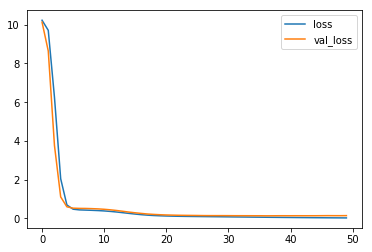

In [29]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

> <font color='blue'>
    We observe that the validation loss starts to increase in the last epochs. In order to avoid this which is a sign of overfitting, the training is prepared to be stopped before this increase. To do this, we will use early stopping.
</font>

In [30]:
def recommender_system_embedding_early_stopping(train_x, train_y, embedding_size, nb_users, nb_items) :
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                               input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                               input_length=1, name='item_embedding')(item_id_input)
    
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    y = Dot(axes=1)([user_vecs, item_vecs])

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    
    model.compile(optimizer='adam', loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    history = model.fit(train_x, train_y, batch_size=64, epochs=50, 
                        validation_split=0.1, shuffle=True, 
                        callbacks=[early_stopping])

    return model, history

In [32]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_embedding_early_stopping(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 1s 63us/step - loss: 10.4349 - val_loss: 10.4726
Epoch 2/50
9000/9000 [==============================] - 0s 14us/step - loss: 9.7633 - val_loss: 8.6023
Epoch 3/50
9000/9000 [==============================] - 0s 15us/step - loss: 5.9422 - val_loss: 3.5180
Epoch 4/50
9000/9000 [==============================] - 0s 15us/step - loss: 1.9745 - val_loss: 1.1325
Epoch 5/50
9000/9000 [==============================] - 0s 14us/step - loss: 0.8039 - val_loss: 0.6862
Epoch 6/50
9000/9000 [==============================] - 0s 15us/step - loss: 0.6094 - val_loss: 0.6154
Epoch 7/50
9000/9000 [==============================] - 0s 15us/step - loss: 0.5775 - val_loss: 0.6023
Epoch 8/50
9000/9000 [==============================] - 0s 15us/step - loss: 0.5657 - val_loss: 0.5895
Epoch 9/50
9000/9000 [==============================] - 0s 15us/step - loss: 0.5534 - val_loss: 0.5795
Epo

> <font color='blue'>
    The mean of the MSE is a bit improved when we use Early Stopping, the MSE going from almost 0.18 to 0.14. As a result, we will keep using Early Stopping with other methods with FC layers.
    </font>

#### 2.4) Matrix factorization approach with embeddings and non linearities (one FC layer)

In [40]:
def recommender_system_deep_1(train_x, train_y, embedding_size, nb_users, nb_items) :
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs])
    input_vecs = Dropout(0.2)(input_vecs)
    x = Dense(64, activation='relu')(input_vecs)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    # early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    # history = model.fit(train_x, train_y, batch_size=64, epochs=50, 
    #                    validation_split=0.1, shuffle=True, 
    #                    callbacks=[early_stopping])
    history = model.fit(train_x, train_y, batch_size=64, epochs=50, 
                        validation_split=0.1, shuffle=True)
    return model, history

In [38]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_1(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 1s 131us/step - loss: 3.8290 - val_loss: 0.7933
Epoch 2/50
9000/9000 [==============================] - 0s 24us/step - loss: 0.7445 - val_loss: 0.7465
Epoch 3/50
9000/9000 [==============================] - 0s 25us/step - loss: 0.7214 - val_loss: 0.7434
Epoch 4/50
9000/9000 [==============================] - 0s 28us/step - loss: 0.6971 - val_loss: 0.7148
Epoch 5/50
9000/9000 [==============================] - 0s 29us/step - loss: 0.6458 - val_loss: 0.6773
Epoch 6/50
9000/9000 [==============================] - 0s 26us/step - loss: 0.6206 - val_loss: 0.6360
Epoch 7/50
9000/9000 [==============================] - 0s 23us/step - loss: 0.5928 - val_loss: 0.6312
Epoch 8/50
9000/9000 [==============================] - 0s 23us/step - loss: 0.5848 - val_loss: 0.6286
Epoch 9/50
9000/9000 [==============================] - 0s 23us/step - loss: 0.5737 - val_loss: 0.6276
Epoc

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 1s 138us/step - loss: 4.1963 - val_loss: 0.7026
Epoch 2/50
9000/9000 [==============================] - 0s 22us/step - loss: 0.6635 - val_loss: 0.5981
Epoch 3/50
9000/9000 [==============================] - 0s 30us/step - loss: 0.6264 - val_loss: 0.5581
Epoch 4/50
9000/9000 [==============================] - 0s 30us/step - loss: 0.5911 - val_loss: 0.5306
Epoch 5/50
9000/9000 [==============================] - 0s 29us/step - loss: 0.5401 - val_loss: 0.4906
Epoch 6/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.5252 - val_loss: 0.4912
Epoch 7/50
9000/9000 [==============================] - 0s 26us/step - loss: 0.5130 - val_loss: 0.4910
Epoch 8/50
9000/9000 [==============================] - 0s 23us/step - loss: 0.5005 - val_loss: 0.4961
Epoch 9/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.4994 - val_loss: 0.4890
Epoch 10/50
9000/9000 [=

> <font color='blue'>
    We see here one of the risks of Early Stopping when the model stops a little too early (Second run where the model stops at 27 epoches) and has not been trained enough to be able to perform well during the testing phase. **But the model with and without FC layers have about the same performance in terms of MSE.** 
    </font>
    
> <font color='blue'>
    Now, let's not use the Early Stopping to see its influence on FC layers.
    </font>

In [41]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_1(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 2s 203us/step - loss: 4.0769 - val_loss: 0.8565
Epoch 2/50
9000/9000 [==============================] - 0s 33us/step - loss: 0.7638 - val_loss: 0.7868
Epoch 3/50
9000/9000 [==============================] - 0s 31us/step - loss: 0.7341 - val_loss: 0.7717
Epoch 4/50
9000/9000 [==============================] - 0s 33us/step - loss: 0.7133 - val_loss: 0.7352
Epoch 5/50
9000/9000 [==============================] - 0s 25us/step - loss: 0.6770 - val_loss: 0.7145
Epoch 6/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.6292 - val_loss: 0.6839
Epoch 7/50
9000/9000 [==============================] - 0s 35us/step - loss: 0.6102 - val_loss: 0.6544
Epoch 8/50
9000/9000 [==============================] - 0s 23us/step - loss: 0.5979 - val_loss: 0.6485
Epoch 9/50
9000/9000 [==============================] - 0s 45us/step - loss: 0.5853 - val_loss: 0.6588
Epoc

> <font color='blue'>
    **According to the results above, we see that when we are using FC layers, it is best not to use the Early Stopping (ES) in order to allow the model learn more even though there may be a risk of overfitting.** Indeed, on average, we obtain a MSE of 0.13 without ES and a MSE of 0.18 with ES.
    </font>
    
> <font color='blue'>
    We will try now to make a more deeper model by adding one another FC layer.
    </font>

#### 2.5) Matrix factorization approach with embeddings and non linearities (2 FC layer)

In [42]:
def recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs])
    x = Dense(64, activation='relu')(input_vecs)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    history = model.fit([train_ratings["user_id"], train_ratings["item_id"]], train_ratings["rating"],
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True)
    
    return model, history

In [43]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 2s 184us/step - loss: 3.6951 - val_loss: 0.7711
Epoch 2/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.8994 - val_loss: 0.6979
Epoch 3/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.8127 - val_loss: 0.6448
Epoch 4/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.7720 - val_loss: 0.6269
Epoch 5/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.7452 - val_loss: 0.6064
Epoch 6/50
9000/9000 [==============================] - 0s 32us/step - loss: 0.7115 - val_loss: 0.6246
Epoch 7/50
9000/9000 [==============================] - 0s 27us/step - loss: 0.6813 - val_loss: 0.5957
Epoch 8/50
9000/9000 [==============================] - 0s 28us/step - loss: 0.6693 - val_loss: 0.6048
Epoch 9/50
9000/9000 [==============================] - 0s 28us/step - loss: 0.6563 - val_loss: 0.5975
Epoc

> <font color='blue'>
    Let's try to decrease the coefficient of drop out from 0.5 to 0.3 in the first FC layer to see whether it is improving the MSE.
    </font>

In [54]:
def recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items) :    
    
    user_id_input = Input(shape=[1],name='user')
    item_id_input = Input(shape=[1], name='item')
    embedding_size = embedding_size
    user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)
    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)
    input_vecs = Concatenate()([user_vecs, item_vecs])
    x = Dense(64, activation='relu')(input_vecs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_id_input, item_id_input], outputs=y)
    model.compile(optimizer='adam', loss='MSE')
    history = model.fit([train_ratings["user_id"], train_ratings["item_id"]], train_ratings["rating"],
                        batch_size=64, epochs=50, validation_split=0.1,
                        shuffle=True)
    
    return model, history

In [55]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 4s 445us/step - loss: 3.1654 - val_loss: 0.6705
Epoch 2/50
9000/9000 [==============================] - 1s 58us/step - loss: 0.7514 - val_loss: 0.6387
Epoch 3/50
9000/9000 [==============================] - 1s 60us/step - loss: 0.6755 - val_loss: 0.5719
Epoch 4/50
9000/9000 [==============================] - 1s 65us/step - loss: 0.6547 - val_loss: 0.5631
Epoch 5/50
9000/9000 [==============================] - 1s 68us/step - loss: 0.6365 - val_loss: 0.5644
Epoch 6/50
9000/9000 [==============================] - 1s 60us/step - loss: 0.6176 - val_loss: 0.5680
Epoch 7/50
9000/9000 [==============================] - 0s 53us/step - loss: 0.6066 - val_loss: 0.5362
Epoch 8/50
9000/9000 [==============================] - 0s 51us/step - loss: 0.5963 - val_loss: 0.5434
Epoch 9/50
9000/9000 [==============================] - 0s 49us/step - loss: 0.5812 - val_loss: 0.5435
Epoc

> <font color='blue'>
    The performance is improved in average when we are decreasing a little bit the Drop out from 0.5 to 0.3, leaving more active neurons !
    </font>
    
> <font color='blue'>
    Let's now test online learning by fiting only the new prediction each time and see if it improves the performance of the recommendation system.
    </font>

In [58]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items)

    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        model.fit([[next_user], [next_item]], [rating])
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 5s 502us/step - loss: 3.8251 - val_loss: 0.8207
Epoch 2/50
9000/9000 [==============================] - 1s 60us/step - loss: 0.8362 - val_loss: 0.7353
Epoch 3/50
9000/9000 [==============================] - 1s 64us/step - loss: 0.7650 - val_loss: 0.6715
Epoch 4/50
9000/9000 [==============================] - 1s 56us/step - loss: 0.7068 - val_loss: 0.6406
Epoch 5/50
9000/9000 [==============================] - 0s 41us/step - loss: 0.6869 - val_loss: 0.6298
Epoch 6/50
9000/9000 [==============================] - 0s 45us/step - loss: 0.6776 - val_loss: 0.6302
Epoch 7/50
9000/9000 [==============================] - 0s 51us/step - loss: 0.6660 - val_loss: 0.6393
Epoch 8/50
9000/9000 [==============================] - 1s 72us/step - loss: 0.6463 - val_loss: 0.6198
Epoch 9/50
9000/9000 [==============================] - 0s 43us/step - loss: 0.6398 - val_loss: 0.6241
Epoc

Epoch 1/1
1/1 [==============================] - 0s 12ms/step - loss: 0.0987
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.2149
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 0.3383
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 0.0266
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 1.8506
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 0.5404
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.2368
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 1.3284
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 0.7968
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 0.7236
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 0.1386
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.4906
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 0.1295
Epoch 1

Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.3188
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5222
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 1.9838
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.9833
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1220
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.1961
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2417
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 0.3253
Epoch 1/1
1/1 [==============================] - 0s 15ms/step - loss: 8.5184e-04
Epoch 1/1
1/1 [==============================] - 0s 12ms/step - loss: 0.0464
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 1/1
1/1 [==============================] - 0s 15ms/step - loss: 1.0733
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.5730
Epo

Epoch 1/1
1/1 [==============================] - 0s 12ms/step - loss: 0.0740
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 0.1267
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 1.5554
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 0.0310
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.2325
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.1134
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 0.1538
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 0.5008
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 0.1982
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.3312
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 1/1
1/1 [==============================] - 0s 16ms/step - loss: 0.3317
Epoch 

> <font color='blue'>
    As we can see, the performance has really declined. Maybe we should not only fit after each new prediction but should we fit many more new predictions at a time, this means that we store the predictions in a liste and after about 10 or more predictions, we fit the model. We will see if it is improving the model.
    </font>

In [61]:
mean = 0
embedding_size = 50
print("Embedding size : %d" % (embedding_size))

for i in range(0, 3) : 

    # Load the data
    data = load_data(url_reset,params)
    user_history = data["user_history"]
    item_history = data["item_history"]
    rating_history = data["rating_history"]
    train_ratings = pd.DataFrame({"user_id": user_history, "item_id": item_history, "rating": rating_history})

    nb_users = data["nb_users"]
    nb_items = data["nb_items"]
    next_user = data["next_user"]
    next_item = data["next_item"]

    nb_samples = 1000
    mse = 0

    train_x = [train_ratings["user_id"], train_ratings["item_id"]]
    train_y = train_ratings["rating"]

    model, history = recommender_system_deep_2(train_x, train_y, embedding_size, nb_users, nb_items)
    
    # For online learning 
    liste_users, liste_items, liste_rating = [], [], []
    
    for j in range(nb_samples) : 
        time.sleep(0.5)
        prediction = model.predict([[next_user], [next_item]])[0][0]
        params["predicted_score"] = prediction
        next_data = requests.get(url=url_predict, params=params).json()
        rating = next_data["rating"]
        
        liste_users.append(next_user)
        liste_items.append(next_item)
        liste_rating.append(rating)
        if j%20 == 0 : 
            model.fit([liste_users, liste_items], liste_rating, verbose=False)
            
        next_user = next_data["next_user"]
        next_item = next_data["next_item"]
        mse += mean_square_error(rating, prediction)

    mean += mse/nb_samples
    print("MSE over 1000 samples on the run %d : %.4f " % (i, mse/nb_samples))

print("Mean of the MSE on 3 independant runs %.4f " % (mean/3))
print("-------------------------------------------")

Embedding size : 50
Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 5s 586us/step - loss: 3.3669 - val_loss: 0.6479
Epoch 2/50
9000/9000 [==============================] - 0s 54us/step - loss: 0.7354 - val_loss: 0.6039
Epoch 3/50
9000/9000 [==============================] - 1s 68us/step - loss: 0.6849 - val_loss: 0.5626
Epoch 4/50
9000/9000 [==============================] - 1s 78us/step - loss: 0.6393 - val_loss: 0.5422
Epoch 5/50
9000/9000 [==============================] - 1s 74us/step - loss: 0.6242 - val_loss: 0.5573
Epoch 6/50
9000/9000 [==============================] - 1s 72us/step - loss: 0.6042 - val_loss: 0.5400
Epoch 7/50
9000/9000 [==============================] - 1s 71us/step - loss: 0.5990 - val_loss: 0.5397
Epoch 8/50
9000/9000 [==============================] - 0s 49us/step - loss: 0.5784 - val_loss: 0.5305
Epoch 9/50
9000/9000 [==============================] - 0s 50us/step - loss: 0.5481 - val_loss: 0.4903
Epoc

> <font color='blue'>
    It is not bad compared to the first one. So, we should do online learning with a pack of 20 or more predictions not only 1 new prediction.
    </font>

### 3) Conclusion 

Our best model in the first environment is : 
- using a deep model with 2 Fully Connected layers
- Embedding size = 50
- Drop out = 0.3
- We can add online learning

- MSE over 1000 samples on the run 0 : 0.1321 
- MSE over 1000 samples on the run 1 : 0.1062 
- MSE over 1000 samples on the run 2 : 0.1049 
- Mean of the MSE on 3 independant runs 0.1144 